In [1]:
#In summary, this code automates the process of matching resumes with job descriptions 
# using natural language processing (NLP) techniques, calculates similarity scores, 
# stores the results, and generates insightful visualizations to analyze the matching patterns.

# 1- Data Loading and Preprocessing:
#-- The script starts by loading two datasets: one containing resumes and another containing job descriptions. 
# It then preprocesses the text by cleaning it—converting all characters to lowercase 
# and removing non-alphanumeric characters.
# --Jobs are filtered to only include those in English.

# 2- Text Vectorization and Similarity Calculation:
# --Both the resumes and job descriptions are combined and transformed into a TF-IDF
#  (Term Frequency-Inverse Document Frequency) matrix, which 
# represents the textual data numerically, with a limit of 5000 features.
# --Cosine similarity is calculated between the vectorized resumes and jobs, 
# providing a measure of how similar each resume is to each job description.

# 3.1- Job Matching: (method 1 : similarity threshold)
# --For each resume, the script identifies jobs with a cosine similarity 
# above a specified threshold (0.01 in this case). It sorts these jobs by similarity 
# and stores the matching job titles and their similarity scores.
# --The results include the top matched jobs for each resume and are saved in two CSV files: 
# one with detailed matches and another showing matches by resume category.

# 3.2- Job Matching: (method 2 : top n jobs)
# --The code matches resumes with the top 5 jobs based on cosine similarity scores. 
# --It iterates through each resume, finds the 5 most similar jobs using the cosine similarity
# values, and stores the job titles and their corresponding IDs.
# --The results are organized into two DataFrames: one containing detailed matches 
# (including resume ID, category, top jobs, job IDs, and similarity scores), 
# and another showing only the category and best-matched job. 
# --Finally, these DataFrames are saved as CSV files for further analysis.

# 4- Visualization:
# --Several visualizations are generated:
# --Distribution of Similarity Scores: A histogram showing how the 
# cosine similarities between resumes and jobs are distributed.
# --Resume Category Distribution: A bar plot visualizing how many resumes belong to each category.
# --Top Categories and Matched Jobs: A bar plot showing the top categories of 
# resumes and the jobs most frequently matched to them.
# --Top N Matched Jobs: A bar plot depicting the most commonly matched job titles.
# --Distribution of Job Matches: Visualizations showing how many resumes are matched 
# with each job and how many jobs are matched with each resume.

# 5- Analysis of Match Types:
# --The code also analyzes the type of relationships between resumes and jobs, 
# such as "one-to-one," "many-to-one," and "many-to-many" matches, and visualizes these relationships.


# my  NB
#keep playing with the similarirty threshold for more filtering
#or use the other code commented method and specify the number of jobs to save per resume
#overall its good

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets (replace paths with your actual file paths)
resumes = pd.read_csv("resumes.csv")  # Columns: ["Category", "Resume"]
jobs = pd.read_csv("jobs.csv")  # Columns: ["Job Title", "Company", "Description", "Language"]


In [3]:
# Preprocessing: Clean text
def preprocess_text(text):
    # Convert to lowercase, remove special characters, extra spaces
    text = str(text).lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

# Clean the text for resumes and jobs
resumes["Resume"] = resumes["Resume"].apply(preprocess_text)
jobs["Description"] = jobs["Description"].apply(preprocess_text)
# Filter jobs to include only those with language 'en'
jobs = jobs[jobs["Language"] == "en"]


In [4]:
# Combine text from resumes and job descriptions for TF-IDF vectorization
all_text = pd.concat([resumes["Resume"], jobs["Description"]])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)

# Split TF-IDF Matrix back into resumes and jobs
resume_vectors = tfidf_matrix[:len(resumes)]
job_vectors = tfidf_matrix[len(resumes):]

# Calculate Cosine Similarity
cosine_similarities = cosine_similarity(resume_vectors, job_vectors)

print(f"Cosine Similarity Matrix Shape: {cosine_similarities.shape}")


Cosine Similarity Matrix Shape: (962, 943)


In [5]:
# Define a similarity threshold (adjust as needed)
SIMILARITY_THRESHOLD = 0.01

# Match resumes with jobs
matches = []
category_job_matches = []
job_ids_per_resume = {}  # Dictionary to store job IDs for each resume

for i, resume in resumes.iterrows():
    # Get all jobs that have a similarity above the threshold
    similar_jobs_indices = [idx for idx, sim in enumerate(cosine_similarities[i]) if sim >= SIMILARITY_THRESHOLD]
    
    # If no jobs meet the threshold, skip this resume
    if not similar_jobs_indices:
        continue
    
    # Sort the selected jobs by similarity in descending order
    sorted_similar_jobs_indices = sorted(similar_jobs_indices, key=lambda idx: cosine_similarities[i, idx], reverse=True)
    
    # Get the jobs and their similarities
    similar_jobs = jobs.iloc[sorted_similar_jobs_indices]
    job_similarities = cosine_similarities[i, sorted_similar_jobs_indices].tolist()
    
    # Store matched job IDs for each resume
    matched_job_ids = similar_jobs.index.tolist()
    job_ids_per_resume[resume.name] = matched_job_ids  # resume.name is the ID of the resume
    
    matches.append({
        "Resume_ID": resume.name,  # Include Resume ID
        "Resume_Category": resume["Category"],
        "Top_Matched_Jobs": similar_jobs["Job Title"].tolist(),
        "Job_IDs": matched_job_ids,  # Include Job IDs
        "Similarities": job_similarities  # Include the similarity values for all matching jobs
    })
    
    # Save Resume Category and Top Matched Job Titles (with high similarity)
    category_job_matches.append({
        "Resume_Category": resume["Category"],
        "Top_Matched_Jobs": similar_jobs["Job Title"].tolist()  # List of matched jobs
    })

# Convert matches to DataFrames
matches_df = pd.DataFrame(matches)
category_job_matches_df = pd.DataFrame(category_job_matches)

# Save results to CSV files
matches_df.to_csv("resume_job_matches_high_similarity.csv", index=False)
category_job_matches_df.to_csv("resume_category_job_matches_high_similarity.csv", index=False)

# Display results: Show Resume ID and the Jobs it Matched to
print("Resume ID and Matched Jobs (Job IDs):")
for resume_id, matched_jobs in job_ids_per_resume.items():
    print(f"Resume ID: {resume_id}, Matched Jobs: {matched_jobs}")




Resume ID and Matched Jobs (Job IDs):
Resume ID: 0, Matched Jobs: [465, 957, 191, 962, 978, 194, 539, 964, 190, 463, 965, 610, 966, 205, 866, 581, 468, 63, 803, 417, 927, 286, 73, 76, 374, 637, 462, 830, 1026, 164, 35, 153, 531, 464, 467, 384, 93, 466, 708, 65, 369, 722, 793, 74, 169, 572, 784, 543, 334, 296, 683, 726, 150, 638, 415, 508, 538, 192, 510, 104, 589, 254, 1014, 1016, 506, 766, 97, 244, 148, 149, 972, 107, 503, 54, 352, 869, 94, 598, 179, 894, 676, 319, 513, 245, 154, 333, 375, 222, 841, 550, 92, 672, 633, 357, 106, 472, 223, 91, 703, 582, 124, 441, 778, 725, 583, 225, 146, 62, 206, 812, 644, 257, 332, 67, 140, 558, 382, 719, 413, 469, 226, 260, 256, 773, 696, 345, 459, 425, 758, 525, 246, 806, 804, 165, 735, 555, 562, 159, 410, 291, 1015, 534, 77, 33, 188, 75, 727, 427, 278, 556, 263, 318, 328, 29, 312, 261, 777, 259, 168, 419, 977, 762, 673, 313, 295, 457, 370, 751, 14, 390, 189, 15, 755, 96, 769, 564, 528, 557, 695, 276, 237, 452, 373, 186, 561, 808, 574, 479, 702, 95, 5

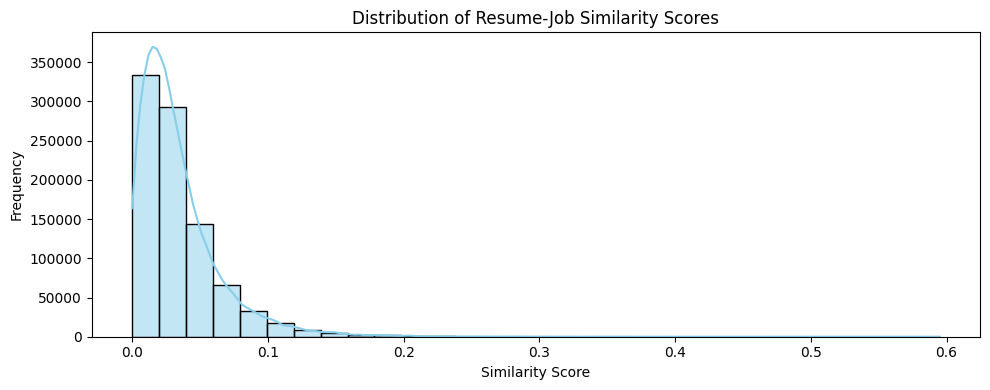

In [6]:
# Visualization
# 1. Distribution of Similarity Scores
all_similarities = cosine_similarities.flatten()
plt.figure(figsize=(10, 4))
sns.histplot(all_similarities, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Resume-Job Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


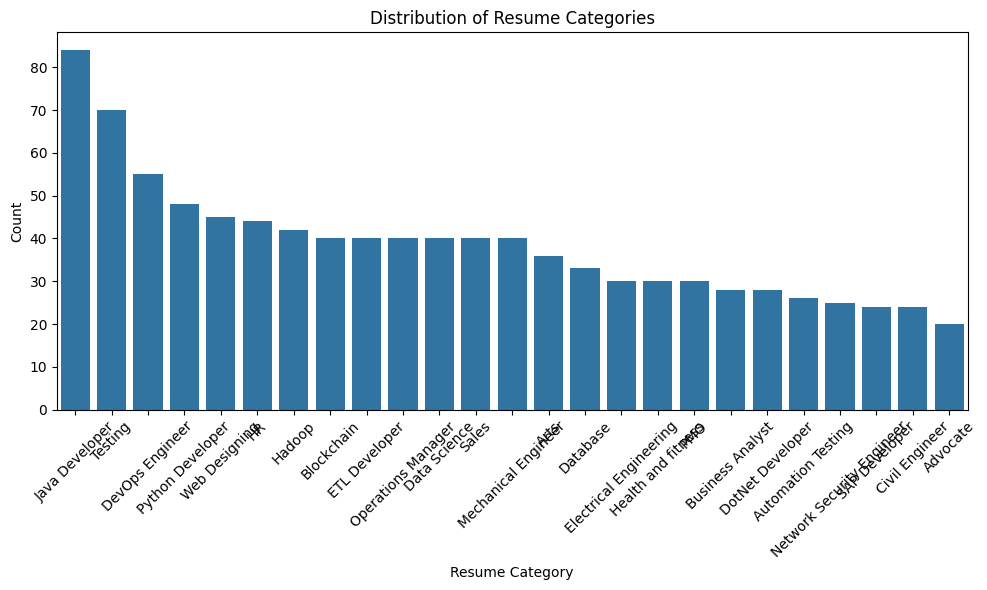

In [7]:
# Bar plot for resume categories
plt.figure(figsize=(10, 6))
sns.countplot(data=resumes, x="Category", order=resumes["Category"].value_counts().index)
plt.title("Distribution of Resume Categories")
plt.xlabel("Resume Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\imane\AppData\Local\Temp\ipykernel_17772\1226782927.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


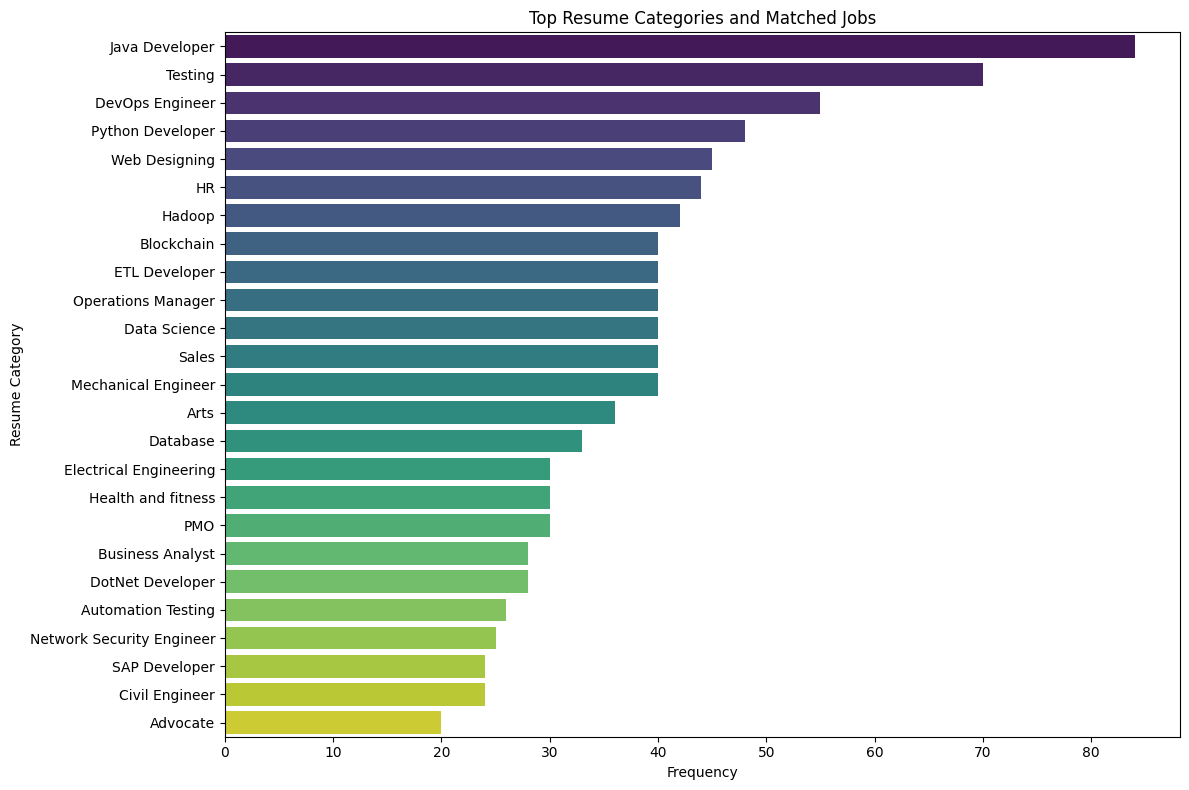

In [8]:
# 2. Top Categories and Matched Jobs
top_categories = category_job_matches_df["Resume_Category"].value_counts().head(25)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title("Top Resume Categories and Matched Jobs")
plt.xlabel("Frequency")
plt.ylabel("Resume Category")
plt.tight_layout()
plt.show()

C:\Users\imane\AppData\Local\Temp\ipykernel_17772\2051421234.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_jobs.values, y=top_n_jobs.index, palette="magma")


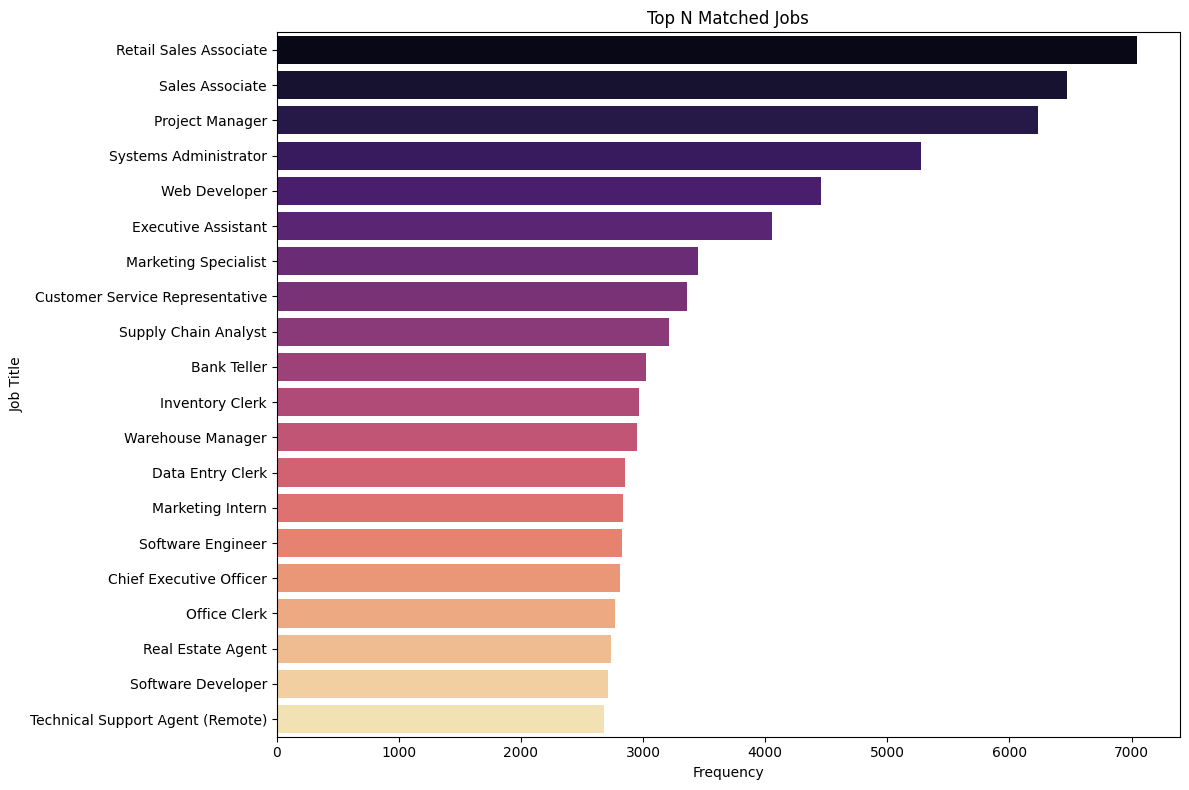

In [9]:
# Visualization 4: Top N Similar Jobs per Resume
top_n_jobs = matches_df.explode("Top_Matched_Jobs")["Top_Matched_Jobs"].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_n_jobs.values, y=top_n_jobs.index, palette="magma")
plt.title("Top N Matched Jobs")
plt.xlabel("Frequency")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()

In [10]:
# 1. Count how many jobs each resume is matched with (Top N matches)
resumes_match_count = matches_df["Top_Matched_Jobs"].apply(len)  # Number of matched jobs per resume

# 2. Count how many resumes each job is matched with
job_match_count = matches_df["Top_Matched_Jobs"].explode().value_counts()  # Number of resumes per job

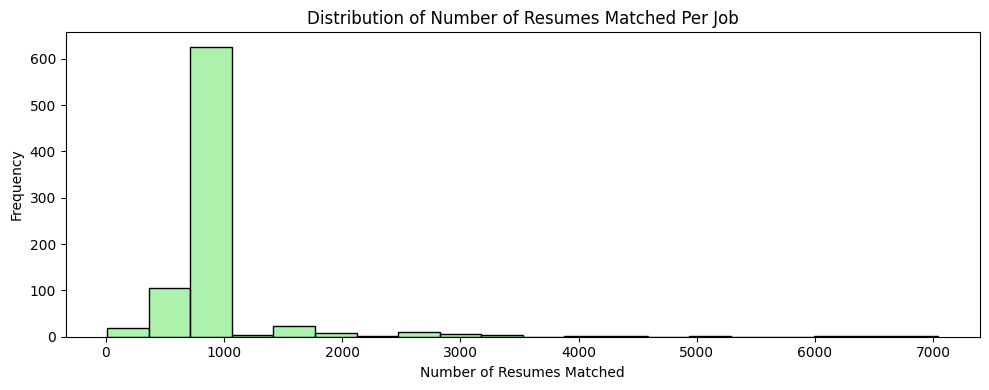

In [11]:
# Visualization 2: Number of Resumes Matched Per Job
plt.figure(figsize=(10, 4))
sns.histplot(job_match_count, kde=False, bins=20, color='lightgreen')
plt.title("Distribution of Number of Resumes Matched Per Job")
plt.xlabel("Number of Resumes Matched")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

C:\Users\imane\AppData\Local\Temp\ipykernel_17772\2432504753.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


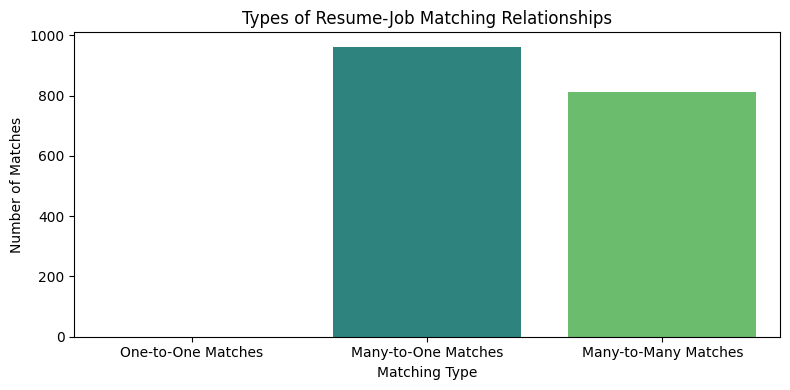

In [12]:
# Visualization 3: Relationship Between Resumes and Jobs (One-to-One, Many-to-One, Many-to-Many)
# If each resume has only one match, it will be a perfect one-to-one match
# We can analyze the proportion of "one-to-one" vs "many-to-one" or "many-to-many" matches

one_to_one_count = len(resumes_match_count[resumes_match_count == 1])
many_to_one_count = len(resumes_match_count[resumes_match_count > 1])
many_to_many_count = len(job_match_count[job_match_count > 1])

# Bar plot showing the type of matching relationships
plt.figure(figsize=(8, 4))
sns.barplot(
    x=["One-to-One Matches", "Many-to-One Matches", "Many-to-Many Matches"],
    y=[one_to_one_count, many_to_one_count, many_to_many_count],
    palette="viridis"
)
plt.title("Types of Resume-Job Matching Relationships")
plt.xlabel("Matching Type")
plt.ylabel("Number of Matches")
plt.tight_layout()
plt.show()

In [13]:
import pickle

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the cosine similarity matrix
with open('cosine_similarities.pkl', 'wb') as f:
    pickle.dump(cosine_similarities, f)


In [14]:
# # Scatter plot for similarities of matched jobs
# similarities = [item for sublist in matches_df["Similarities"] for item in sublist]
# plt.figure(figsize=(10, 6))
# plt.scatter(range(len(similarities)), similarities, alpha=0.5, color='blue')
# plt.title("Scatter Plot of Cosine Similarity Scores")
# plt.xlabel("Matched Pair Index")
# plt.ylabel("Cosine Similarity")
# plt.tight_layout()
# plt.show()


In [15]:
#Scatter plot for similarities of matched jobs

#Interpretation: 
# The distribution suggests that the majority of the pairs have relatively low similarity, 
# which is expected in many real-world matching tasks. 
# If you are expecting higher similarity scores (for example, if you anticipate high-quality matches), 
# you might want to investigate why the majority of the matches have low similarity. 
# The few outliers with high similarity scores are good to note as they represent the stronger matches.

#Improvement: 
# If the plot is intended to highlight good matches, 
# you may want to explore ways to improve similarity by fine-tuning your matching process or thresholds. 
# Alternatively, visual enhancements like adjusting point size, color gradients,
# or zooming in on specific similarity ranges might improve readability and insight extraction.